In [446]:
import pandas as pd
import os

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scikit_posthocs as sp
from scipy.stats import f_oneway
from scipy.stats import ttest_ind_from_stats


## Helpful functions

In [ ]:
def test_normality(arr_pd, show_qq_plot=False, normality_test='kolmogorov'):
    """
    Test normality for each group in array
    """
    num_groups = arr_pd.shape[1]
    rejected_normal_groups_l = [False] * num_groups
    normality_results = []
    # Step 1 : Check normality of each interval
    for group_i in range(num_groups):
        sample = arr_pd.iloc[:, group_i].dropna().values

        if show_qq_plot:
            sm.qqplot(sample)
            plt.show()

        if normality_test == 'kolmogorov':
            norm_result = stats.kstest(sample, 'norm')
            norm_pvalue = norm_result.pvalue
        elif normality_test == 'shapiro':
            norm_result = stats.shapiro(sample)
            norm_pvalue = norm_result[1]
        else:
            raise ValueError(f'{normality_test} value error, kolmogorov or shapiro options available')
        # Reject two-sided null hypothesis (identical to norm distribution) for p < 0.05
        if norm_pvalue < 0.05:
            print(f'Interval: {arr_pd.columns[group_i]} != normal')
            rejected_normal_groups_l[group_i] = True
        else:
            print(f'Interval: {arr_pd.columns[group_i]} == normal')

        normality_results.append(norm_pvalue)
    rejected_normal_groups_np = np.array(rejected_normal_groups_l)

    return rejected_normal_groups_np, normality_results

def two_tailed_ttest(arr_pd, col1, col2, is_unpaired=True):
    if is_unpaired:
        return stats.ttest_ind(arr_pd[col1].dropna(), arr_pd[col2].dropna()).pvalue
    else:
        return stats.ttest_rel(arr_pd[col1].dropna(), arr_pd[col2].dropna()).pvalue
    

def get_stats_multiple_groups(arr_pd, show_qq_plot=False, normality_test='kolmogorov', force_parametric=False):
    assert arr_pd.shape[1] > 2

    rejected_normal_groups_np, kstest_result = test_normality(arr_pd, show_qq_plot=show_qq_plot, normality_test=normality_test)

    stat_result = None

    arr_pd_melt = pd.melt(arr_pd, var_name='interval', value_name='value').dropna()
    # Case: Some or all intervals are NOT normal:
    # We may choose to force parametric approach anyways
    if np.sum(rejected_normal_groups_np) > 0 and (not force_parametric):
        print('Non-normal groups -> Kruskal')
        # use kruskal-wallis

        #x = [arr_pd.iloc[:, i].dropna() for i in range(arr_pd.shape[1])]
        #print(stats.kruskal(*x))
        kruskal_result = stats.kruskal(*[group['value'].values for name, group in arr_pd_melt.groupby("interval")])
        print(kruskal_result)

        # On rejection apply post-hoc Dunn w\ bonferroni p adjustment correction
        if kruskal_result.pvalue < 0.05:
            print('Rejection: kruskal')
            post_hoc_result = sp.posthoc_dunn(arr_pd_melt, val_col='value', group_col='interval', p_adjust='bonferroni')
            print('Dunn-bonferroni output', post_hoc_result)
    #Case: All intervals are normal
    else:
        if force_parametric:
            print(f'Force parametric: Anova, num normal groups: {np.sum(~rejected_normal_groups_np)}/{len(rejected_normal_groups_np)}')
        else:
            print('All normal groups -> Anova')
        # Apply anova one-way
        anova_result = f_oneway(*[group['value'].values for name, group in arr_pd_melt.groupby("interval")])
        print(anova_result)

        if anova_result.pvalue < 0.05:
            print('Rejection: anova')
            # On rejection apply tukey's test
            tukey_result = pairwise_tukeyhsd(arr_pd_melt['value'], arr_pd_melt['interval'])

            #display results
            print('Tukey output', tukey_result)
    


In [447]:
base_folder = '/Users/achilleasgeorgiou/Desktop/data_output/'
show_qq_plots =True

# Figure 1

/Users/achilleasgeorgiou/Desktop/data_output/misc/capsid_density_data.csv
     hour_1     day_10  cell_body
0  9.400000  13.700000   31.19128
1  7.800000   8.747743   41.00000
2  7.645113  23.882290   29.00000
3  7.506638  21.589300   26.90802
4  6.388628  16.303270   36.84701


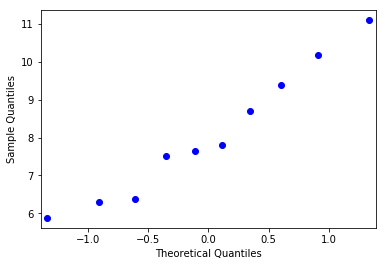

Interval: hour_1 == normal


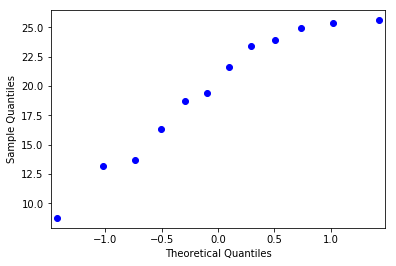

Interval: day_10 == normal


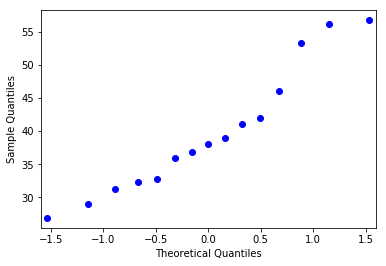

Interval: cell_body == normal
Normality p-values [0.6420902013778687, 0.23542803525924683, 0.1922445297241211]
hour_1 <-> day_10 ttest hypothesis rejected : 4.11e-06
day_10 <-> cell_body ttest hypothesis rejected: 8.14e-07


In [448]:
plot_folder = 'misc'

data_path = 'capsid_density_data.csv'

full_path = os.path.join(base_folder, plot_folder, data_path)
print(full_path)
arr_pd = pd.read_csv(full_path, index_col=0)
print(arr_pd.head())

rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

print('Normality p-values', normality_results)
# Quick check that all are normal (not rejected)
assert np.sum(rejected_normal_groups_np) == 0


# Use unpaired-t-test between groups [hour_1, day_10] (which is day_12 is paper), [day_10, cell_body]
hour_day_result = two_tailed_ttest(arr_pd, 'hour_1', 'day_10', is_unpaired=True)
day_cell_result = two_tailed_ttest(arr_pd, 'day_10', 'cell_body', is_unpaired=True)

if hour_day_result < 0.05:
    print(f'hour_1 <-> day_10 ttest hypothesis rejected : {hour_day_result:.3}')

if hour_day_result < 0.05:
    print(f'day_10 <-> cell_body ttest hypothesis rejected: {day_cell_result:.3}')

# Figure 2

## rest to run

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/rest_to_run_durations/range_30_61-step_10range_30_61-step_10-data.csv
For plot: rest_to_run_durations/range_30_61-step_10range_30_61-step_10-data.csv


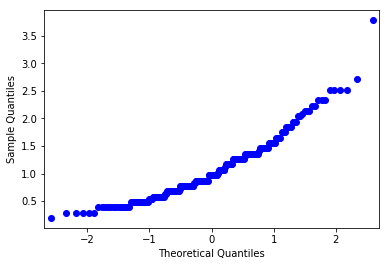

Interval: -30 != normal


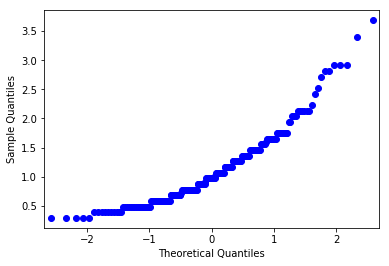

Interval: -20 != normal


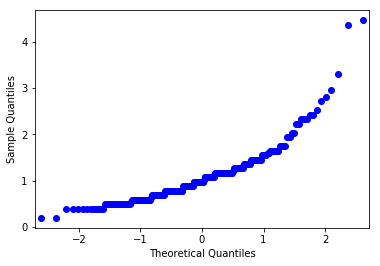

Interval: -10 != normal


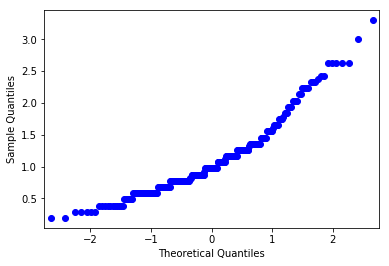

Interval: 0 != normal


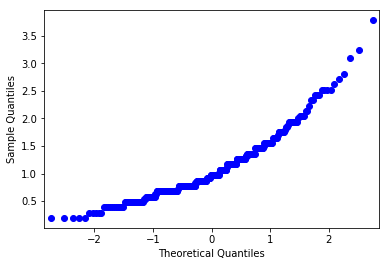

Interval: 10 != normal


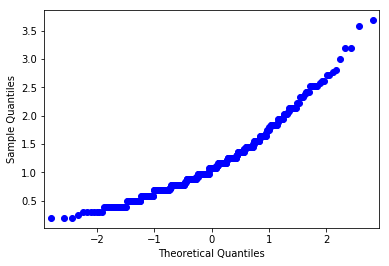

Interval: 20 != normal


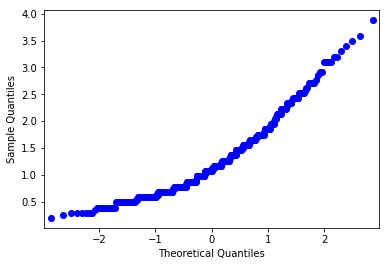

Interval: 30 != normal


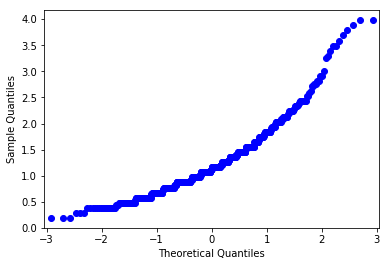

Interval: 40 != normal


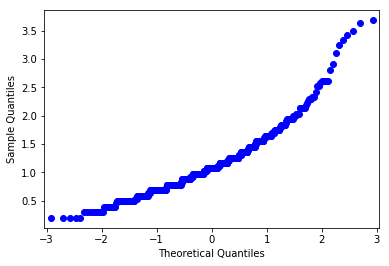

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=36.48407479292964, pvalue=1.4315658993929884e-05)
Rejection: kruskal
Dunn-bonferroni output           -10       -20       -30         0        10   20        30  \
-10  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.258498   
-20  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.458221   
-30  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.155049   
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.514014   
10   1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.053917   
20   1.000000  1.000000  1.000000  1.000000  1.000000  1.0  1.000000   
30   0.258498  0.458221  0.155049  0.514014  0.053917  1.0  1.000000   
40   0.019952  0.045895  0.011376  0.042185  0.001596  1.0  1.000000   
50   1.000000  1.000000  0.953657  1.000000  0.502391  1.0  1.000000   

           40        50  
-10  0.019952  1.000000  
-20  0.045895  1.000000  
-30  0.011376  0.953657  
0    0.

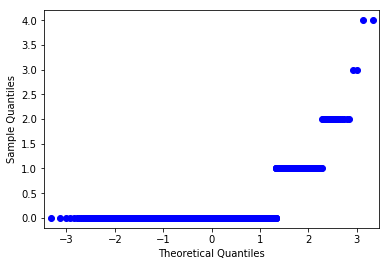

Interval: -30 != normal


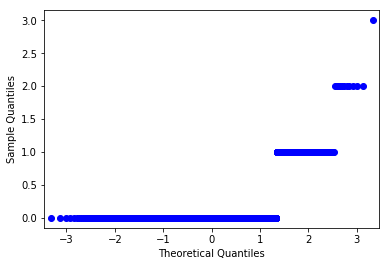

Interval: -20 != normal


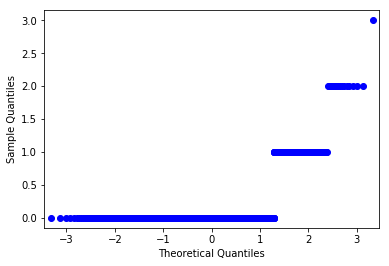

Interval: -10 != normal


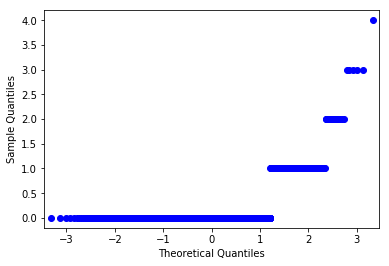

Interval: 0 != normal


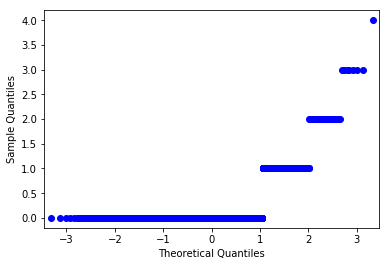

Interval: 10 != normal


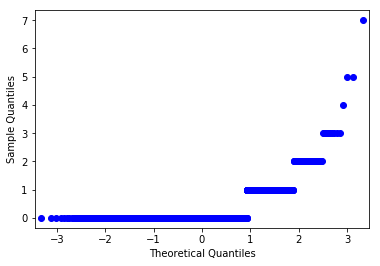

Interval: 20 != normal


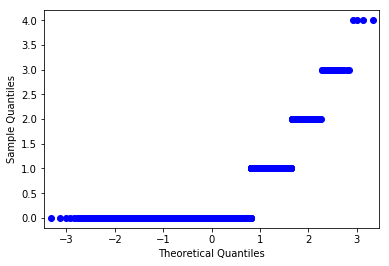

Interval: 30 != normal


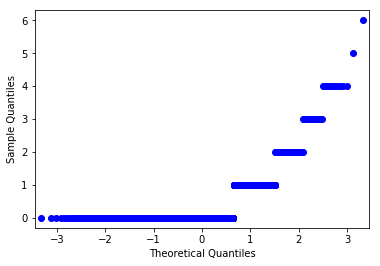

Interval: 40 != normal


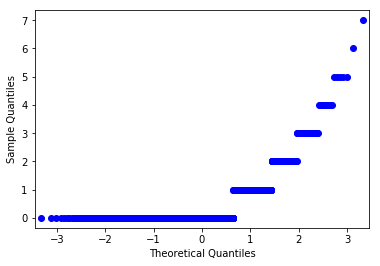

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=670.8852521036304, pvalue=1.3234630950905748e-139)
Rejection: kruskal
Dunn-bonferroni output               -10           -20           -30             0            10  \
-10  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  3.281789e-04   
-20  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  5.217089e-06   
-30  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.881681e-05   
0    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  4.371452e-02   
10   3.281789e-04  5.217089e-06  1.881681e-05  4.371452e-02  1.000000e+00   
20   1.062338e-11  1.700888e-14  1.204648e-13  3.940355e-08  1.527640e-01   
30   1.179303e-23  1.549925e-27  2.287015e-26  1.674989e-18  1.049636e-07   
40   8.084125e-49  2.577441e-54  1.132813e-52  2.626411e-41  3.513410e-24   
50   1.987920e-50  5.185819e-56  2.417450e-54  8.659112e-43  2.547296e-25   

               20            30            40            50 

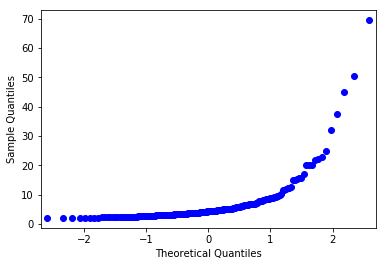

Interval: -30 != normal


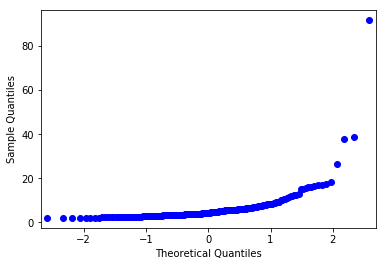

Interval: -20 != normal


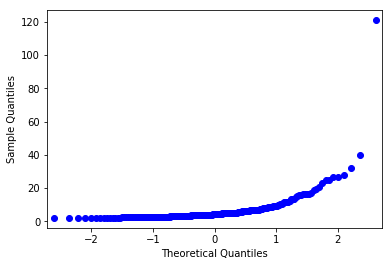

Interval: -10 != normal


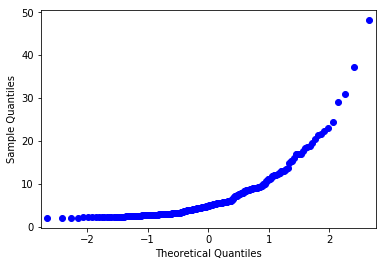

Interval: 0 != normal


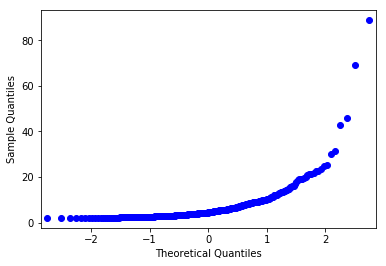

Interval: 10 != normal


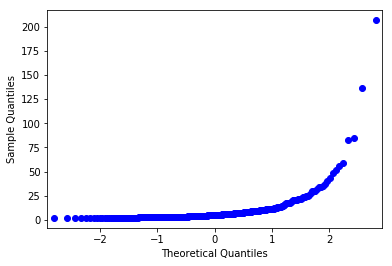

Interval: 20 != normal


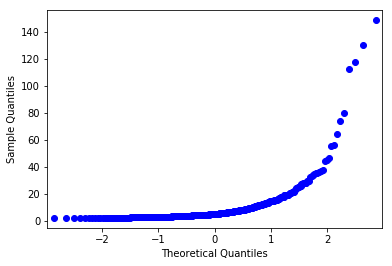

Interval: 30 != normal


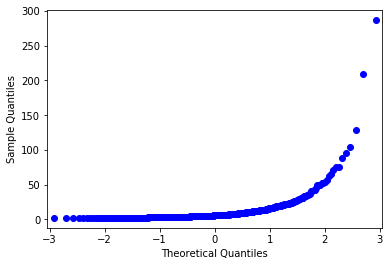

Interval: 40 != normal


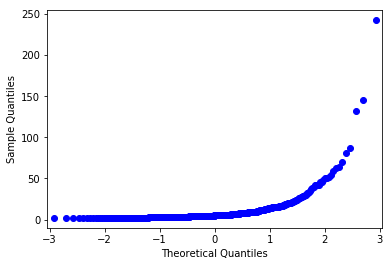

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=46.569550680385206, pvalue=1.8521046649746787e-07)
Rejection: kruskal
Dunn-bonferroni output           -10       -20       -30         0        10        20        30  \
-10  1.000000  1.000000  1.000000  1.000000  1.000000  0.515462  0.146578   
-20  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.421703   
-30  1.000000  1.000000  1.000000  1.000000  1.000000  0.576430  0.173636   
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.519122   
20   0.515462  1.000000  0.576430  1.000000  1.000000  1.000000  1.000000   
30   0.146578  0.421703  0.173636  1.000000  0.519122  1.000000  1.000000   
40   0.000182  0.001250  0.000296  0.070267  0.000434  0.616333  1.000000   
50   0.122949  0.376463  0.148599  1.000000  0.438996  1.000000  1.000000   

           40        50  
-10  0.000182  0.122949  
-20  0.0

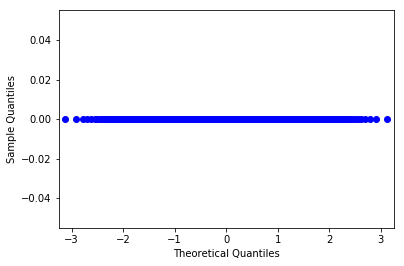

Interval: -30 != normal


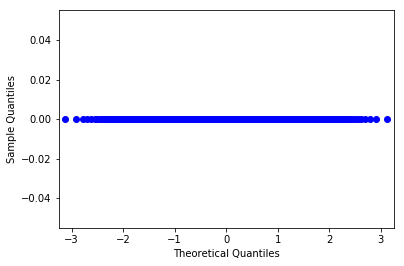

Interval: -25 != normal


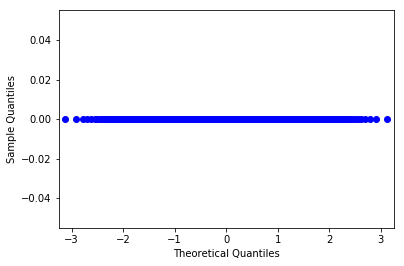

Interval: -20 != normal


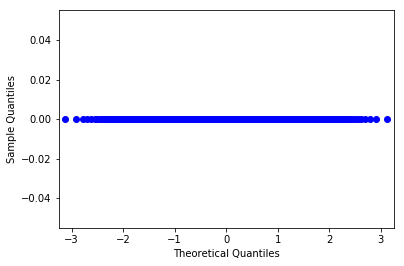

Interval: -15 != normal


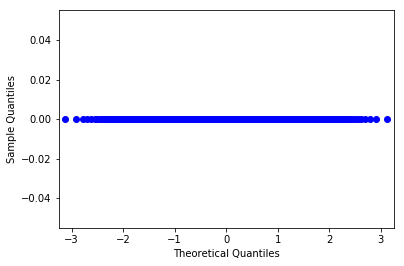

Interval: -10 != normal


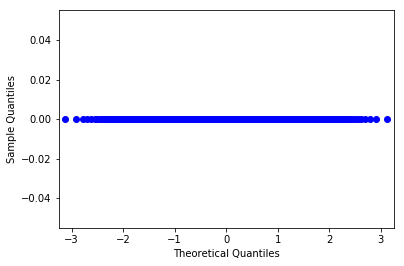

Interval: -5 != normal


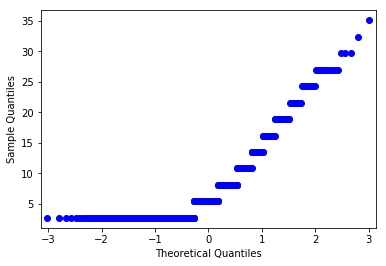

Interval: 0 != normal


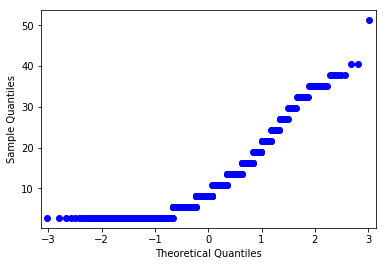

Interval: 5 != normal


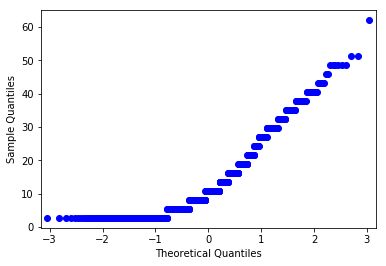

Interval: 10 != normal


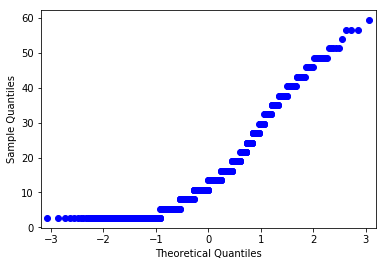

Interval: 15 != normal


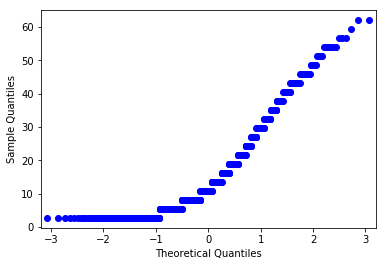

Interval: 20 != normal


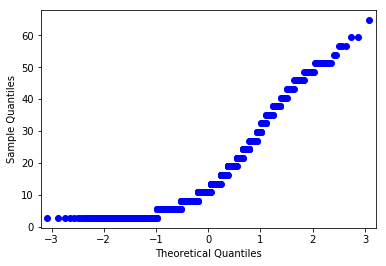

Interval: 25 != normal


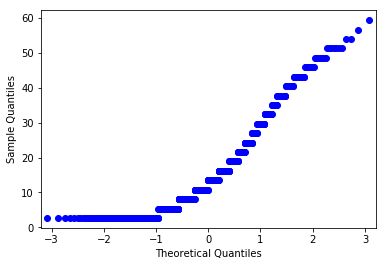

Interval: 30 != normal


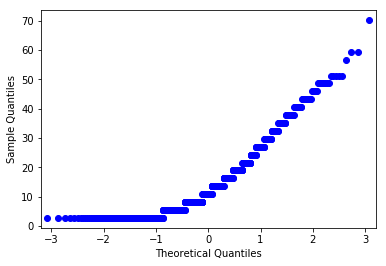

Interval: 35 != normal


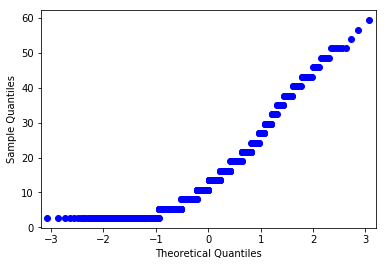

Interval: 40 != normal


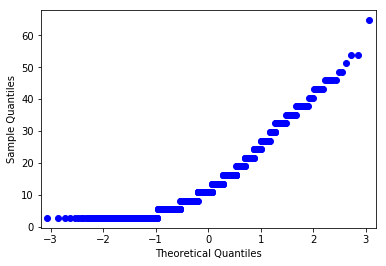

Interval: 45 != normal


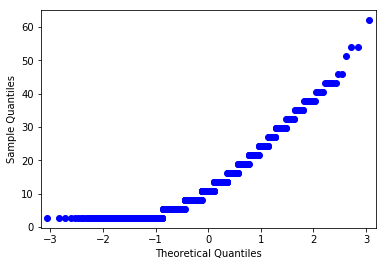

Interval: 50 != normal


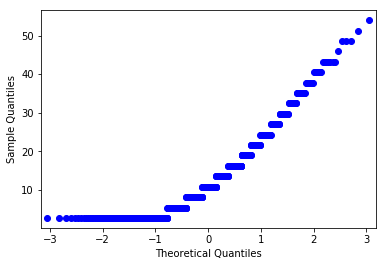

Interval: 55 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=13443.503041236, pvalue=0.0)
Rejection: kruskal
Dunn-bonferroni output                -10            -15            -20            -25  \
-10   1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   
-15   1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   
-20   1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   
-25   1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   
-30   1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   
-5    1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   
0    6.790872e-202  6.790872e-202  6.790872e-202  6.790872e-202   
10    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
15    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
20    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
25    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
30    0.000000e+00   0.000000e+00   0.000000e+00 

In [449]:
plot_folder = 'dataset_1_all/all/plots'
rest_to_run_data_paths = ["rest_to_run_durations/range_30_61-step_10range_30_61-step_10-data.csv",
                            "rest_to_run_proportions/range_30_61-step_10range_30_61-step_10-data.csv",
                            "rest_to_run_sizes/range_30_61-step_10range_30_61-step_10-data.csv", 
                            "rest_to_run_speed/range_30_61-step_5range_30_61-step_5-data.csv"]

for data_path in rest_to_run_data_paths:
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)
    
    print(f'For plot: {data_path}')
    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots)

    print('------------\n\n\n\n')


## run stick run

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_amplitudes/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_amplitudes/range_20_41-step_10range_20_41-step_10-data.csv


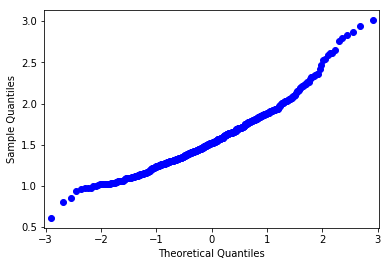

Interval: -20 != normal


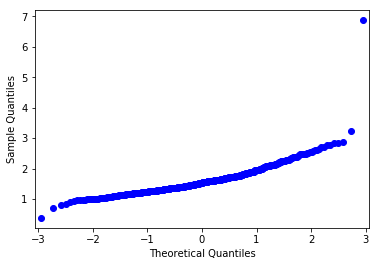

Interval: -10 != normal


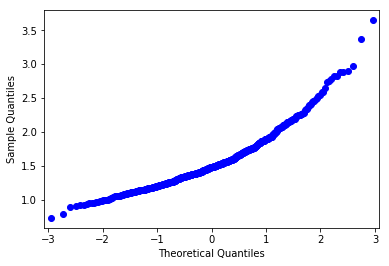

Interval: 0 != normal


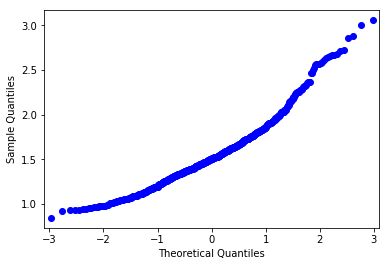

Interval: 10 != normal


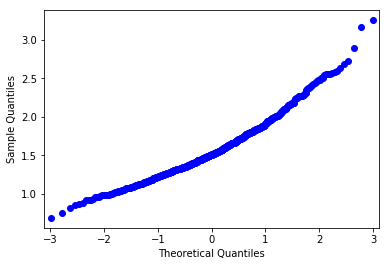

Interval: 20 != normal


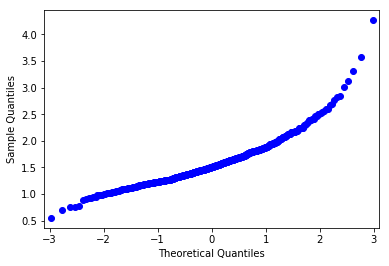

Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=5.066927140759383, pvalue=0.4077670789668611)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_durations/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_durations/range_20_41-step_10range_20_41-step_10-data.csv


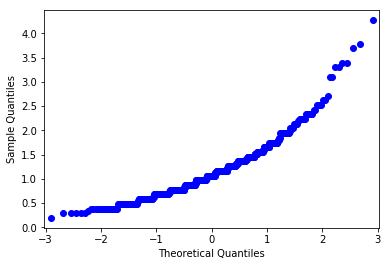

Interval: -20 != normal


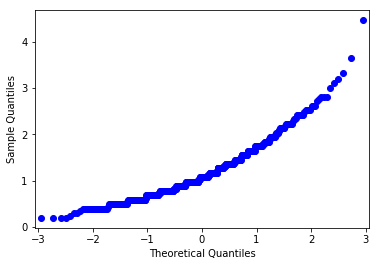

Interval: -10 != normal


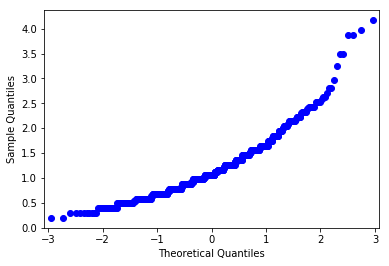

Interval: 0 != normal


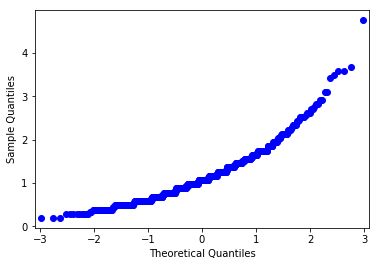

Interval: 10 != normal


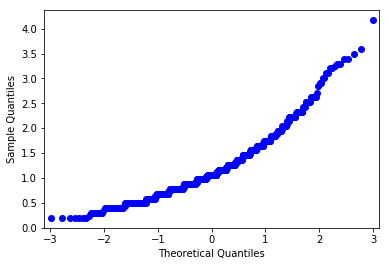

Interval: 20 != normal


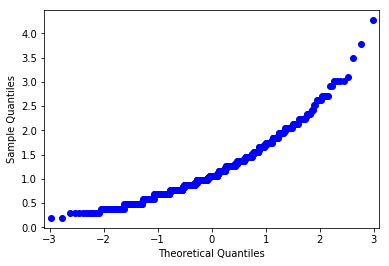

Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=1.3969146266669021, pvalue=0.9246504817816891)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_proportions/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_proportions/range_20_41-step_10range_20_41-step_10-data.csv


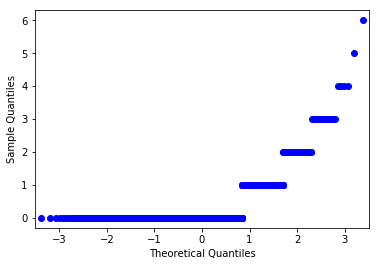

Interval: -20 != normal


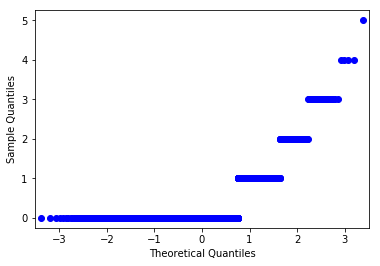

Interval: -10 != normal


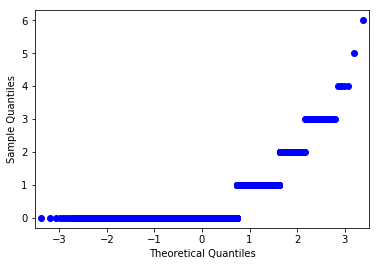

Interval: 0 != normal


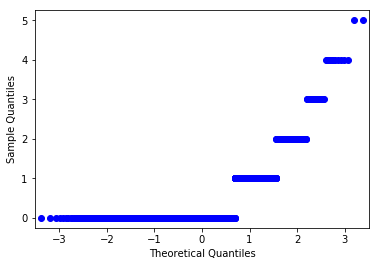

Interval: 10 != normal


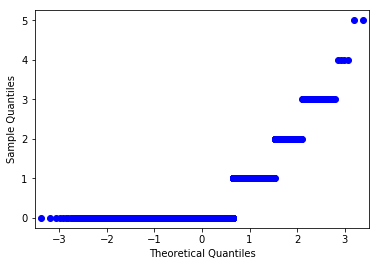

Interval: 20 != normal


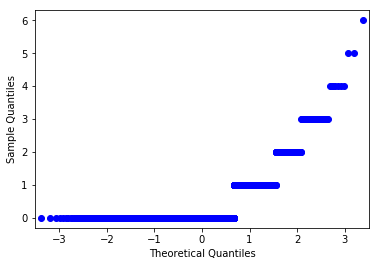

Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=37.66391792361976, pvalue=4.4076167137137393e-07)
Rejection: kruskal
Dunn-bonferroni output           -10       -20         0        10        20        30
-10  1.000000  0.314619  1.000000  0.759234  0.041363  0.281660
-20  0.314619  1.000000  0.066828  0.000302  0.000002  0.000048
0    1.000000  0.066828  1.000000  1.000000  0.209574  1.000000
10   0.759234  0.000302  1.000000  1.000000  1.000000  1.000000
20   0.041363  0.000002  0.209574  1.000000  1.000000  1.000000
30   0.281660  0.000048  1.000000  1.000000  1.000000  1.000000
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_sizes/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_sizes/range_20_41-step_10range_20_41-step_10-data.csv


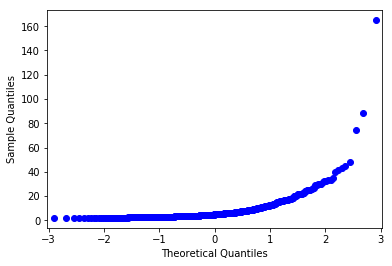

Interval: -20 != normal


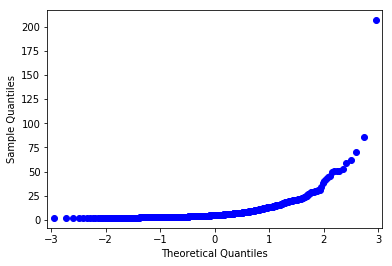

Interval: -10 != normal


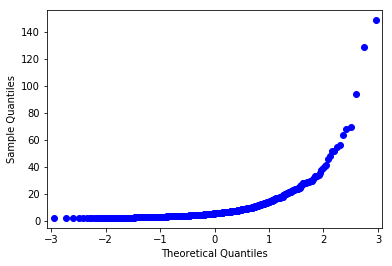

Interval: 0 != normal


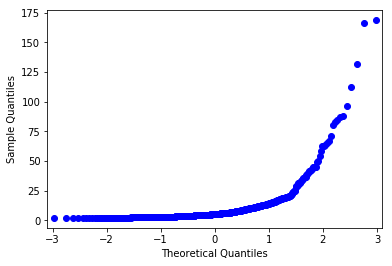

Interval: 10 != normal


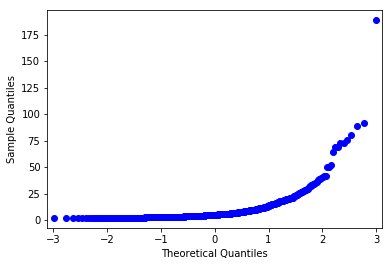

Interval: 20 != normal


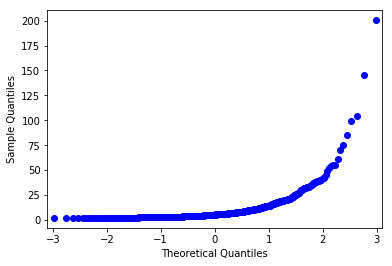

Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=7.666942136268006, pvalue=0.17557156217467942)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_speed/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_speed/range_20_41-step_10range_20_41-step_10-data.csv


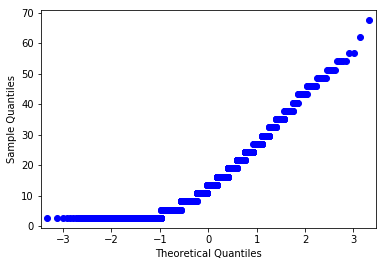

Interval: -20 != normal


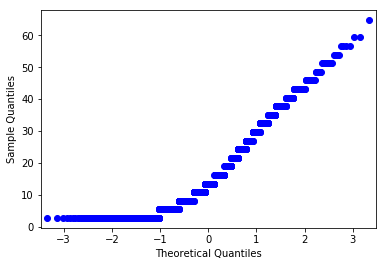

Interval: -10 != normal


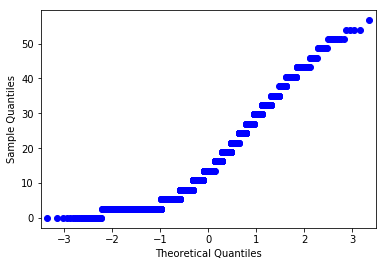

Interval: 0 != normal


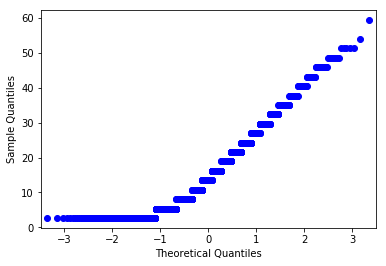

Interval: 10 != normal


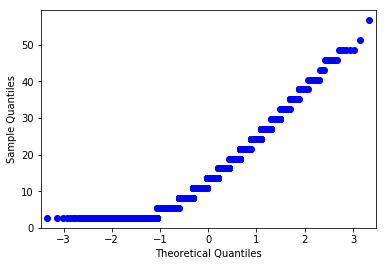

Interval: 20 != normal


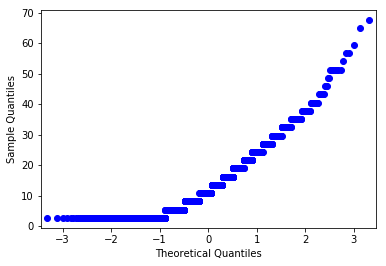

Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=62.303397676995246, pvalue=4.0580252519855945e-12)
Rejection: kruskal
Dunn-bonferroni output               -10       -20             0            10        20  \
-10  1.000000e+00  0.138114  1.000000e+00  1.000000e+00  0.030967   
-20  1.381135e-01  1.000000  2.684960e-01  3.666427e-02  1.000000   
0    1.000000e+00  0.268496  1.000000e+00  1.000000e+00  0.066609   
10   1.000000e+00  0.036664  1.000000e+00  1.000000e+00  0.006627   
20   3.096680e-02  1.000000  6.660857e-02  6.627104e-03  1.000000   
30   1.459804e-08  0.007268  5.456135e-08  8.300630e-10  0.031197   

               30  
-10  1.459804e-08  
-20  7.267554e-03  
0    5.456135e-08  
10   8.300630e-10  
20   3.119715e-02  
30   1.000000e+00  
------------






In [451]:
plot_folder = 'dataset_1_all/all/plots'
run_stick_run_data_paths = ["run_stick_run_amplitudes/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_durations/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_proportions/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_sizes/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_speed/range_20_41-step_10range_20_41-step_10-data.csv"]

for data_path in run_stick_run_data_paths:
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)
    
    print(f'For plot: {data_path}')
    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots)

    print('------------\n\n\n\n')

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_to_rest_amplitudes/range_30_61-step_10range_30_61-step_10-data.csv
For plot: run_to_rest_amplitudes/range_30_61-step_10range_30_61-step_10-data.csv


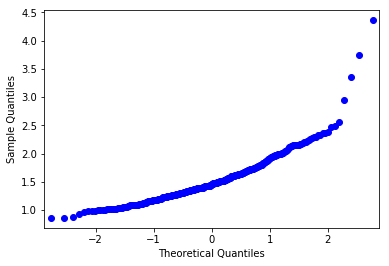

Interval: -30 != normal


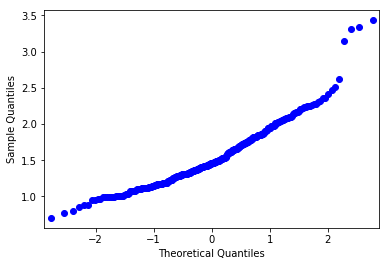

Interval: -20 != normal


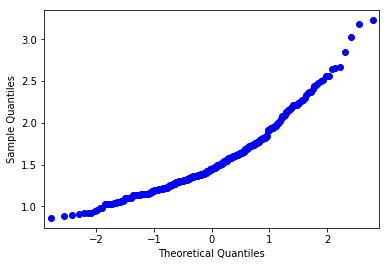

Interval: -10 != normal


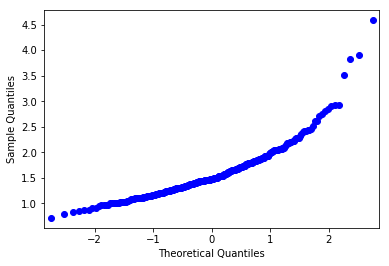

Interval: 0 != normal


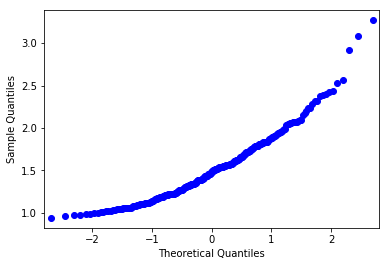

Interval: 10 != normal


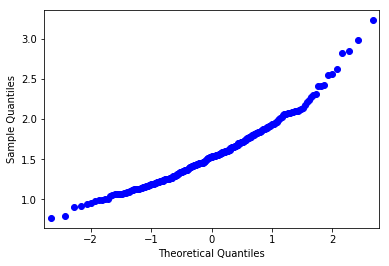

Interval: 20 != normal


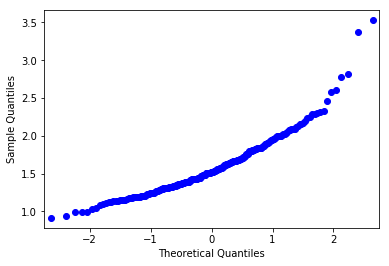

Interval: 30 != normal


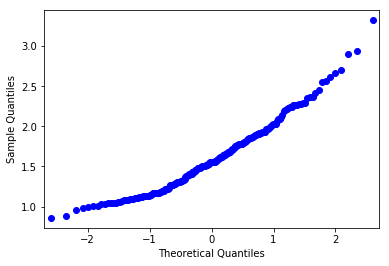

Interval: 40 != normal


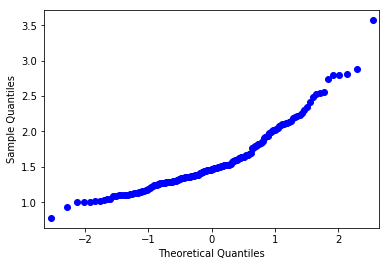

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=12.421308627409417, pvalue=0.13337274433150498)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_to_rest_durations/range_30_61-step_10range_30_61-step_10-data.csv
For plot: run_to_rest_durations/range_30_61-step_10range_30_61-step_10-data.csv


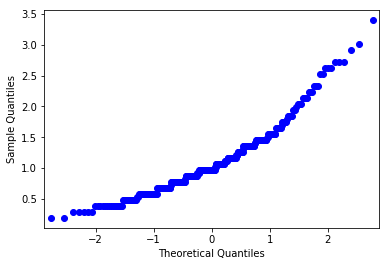

Interval: -30 != normal


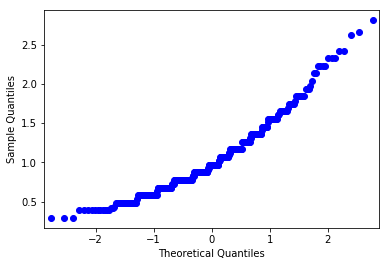

Interval: -20 != normal


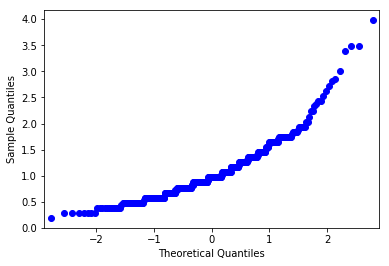

Interval: -10 != normal


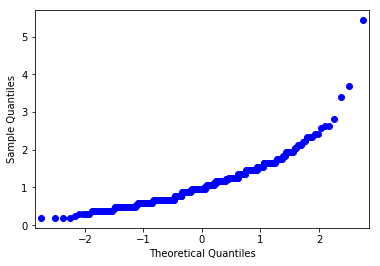

Interval: 0 != normal


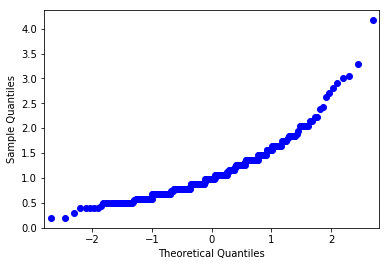

Interval: 10 != normal


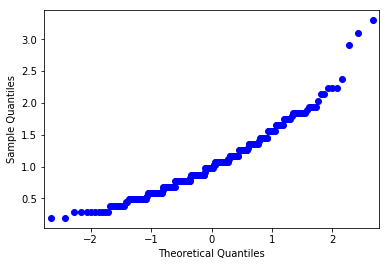

Interval: 20 != normal


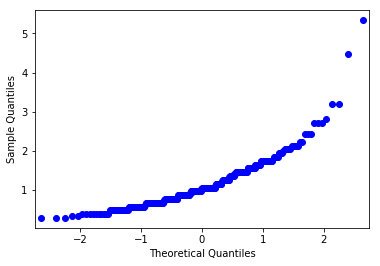

Interval: 30 != normal


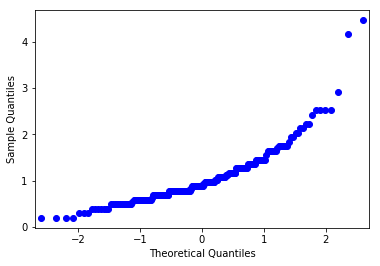

Interval: 40 != normal


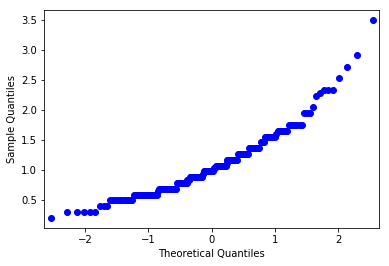

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=6.612294593441464, pvalue=0.5789805692553358)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_to_rest_proportions/range_30_61-step_10range_30_61-step_10-data.csv
For plot: run_to_rest_proportions/range_30_61-step_10range_30_61-step_10-data.csv


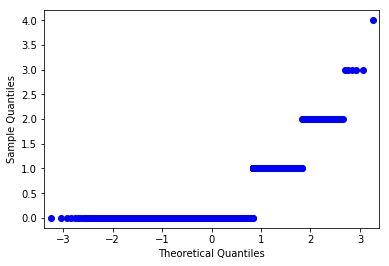

Interval: -30 != normal


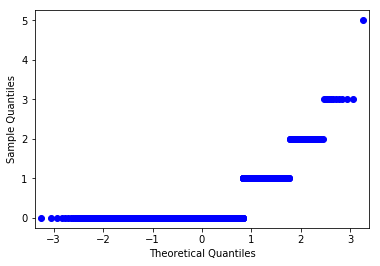

Interval: -20 != normal


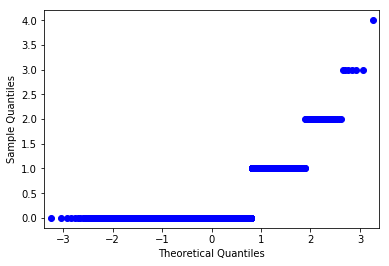

Interval: -10 != normal


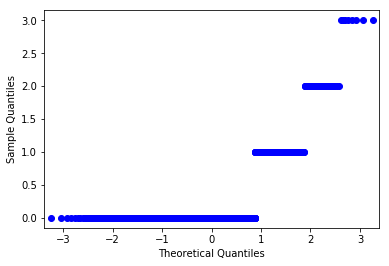

Interval: 0 != normal


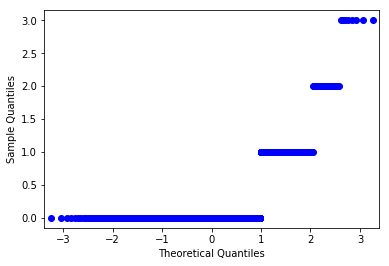

Interval: 10 != normal


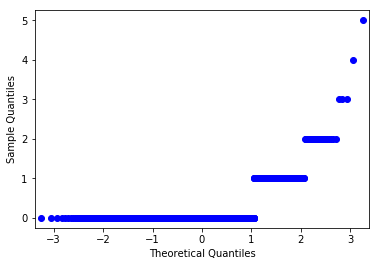

Interval: 20 != normal


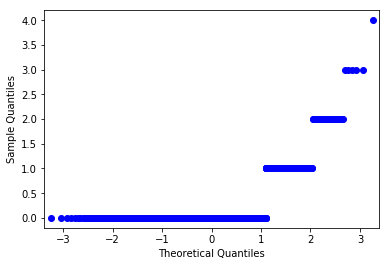

Interval: 30 != normal


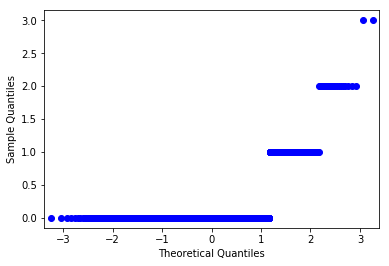

Interval: 40 != normal


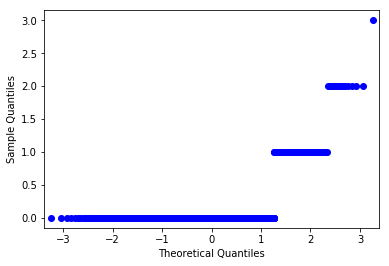

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=166.88870770666125, pvalue=5.785252120672046e-32)
Rejection: kruskal
Dunn-bonferroni output               -10           -20           -30             0        10  \
-10  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.003127   
-20  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.013412   
-30  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.020173   
0    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.684196   
10   3.126545e-03  1.341183e-02  2.017256e-02  6.841958e-01  1.000000   
20   9.995220e-06  6.561607e-05  1.119339e-04  1.341314e-02  1.000000   
30   1.584054e-07  1.347744e-06  2.482754e-06  6.456730e-04  1.000000   
40   2.408416e-11  3.283033e-10  6.955345e-10  7.437735e-07  0.039974   
50   1.466441e-16  3.420645e-15  8.499508e-15  4.574074e-11  0.000072   

           20            30            40            50  
-10  0.000010  1.584054e-07  2.408416e-11  

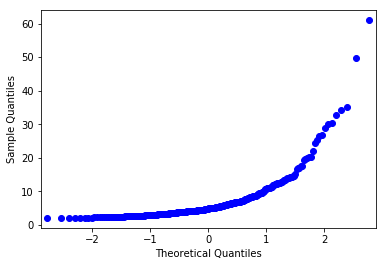

Interval: -30 != normal


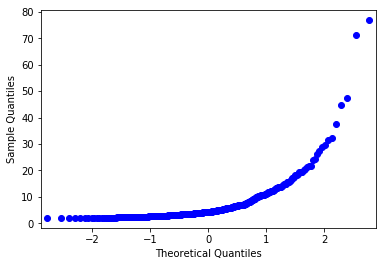

Interval: -20 != normal


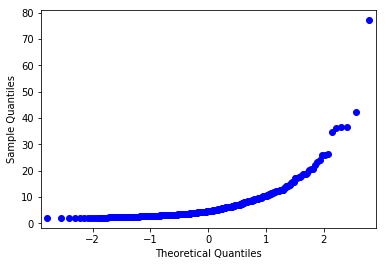

Interval: -10 != normal


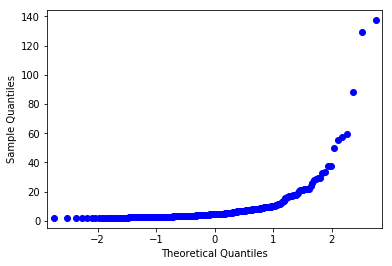

Interval: 0 != normal


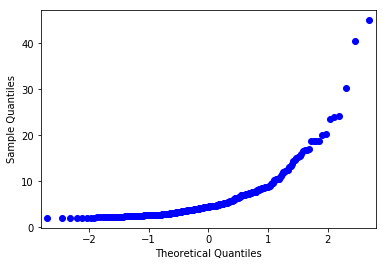

Interval: 10 != normal


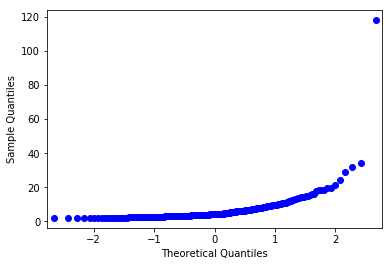

Interval: 20 != normal


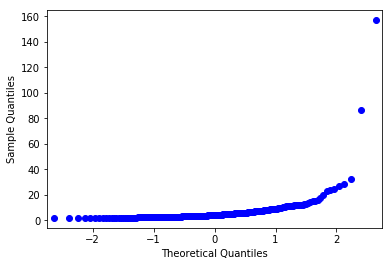

Interval: 30 != normal


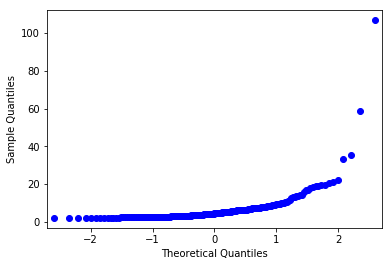

Interval: 40 != normal


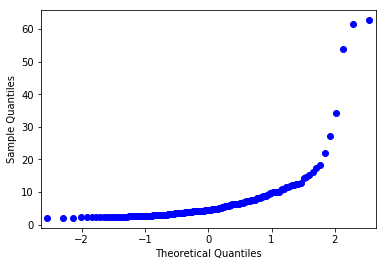

Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=7.9300077993379965, pvalue=0.44033692876620467)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_to_rest_speed/range_30_61-step_5range_30_61-step_5-data.csv
For plot: run_to_rest_speed/range_30_61-step_5range_30_61-step_5-data.csv


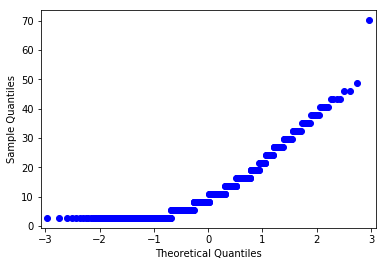

Interval: -30 != normal


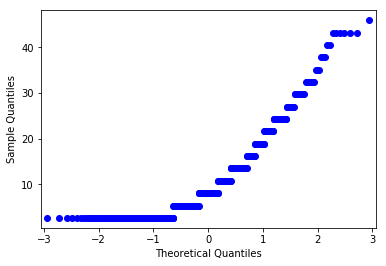

Interval: -25 != normal


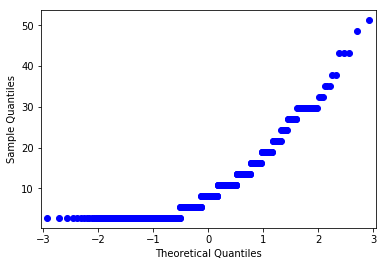

Interval: -20 != normal


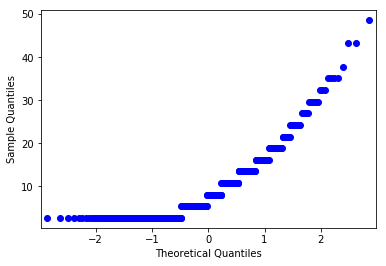

Interval: -15 != normal


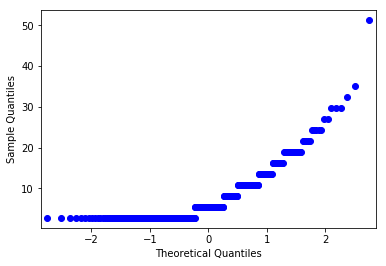

Interval: -10 != normal


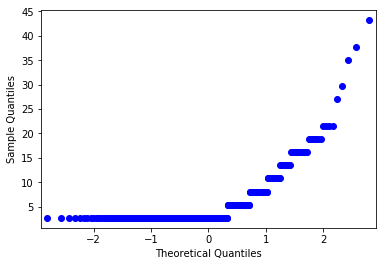

Interval: -5 != normal


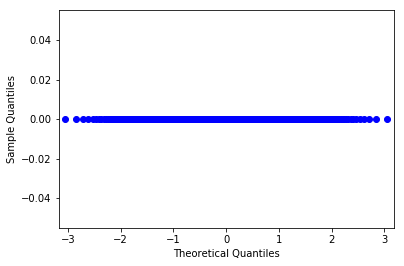

Interval: 0 != normal


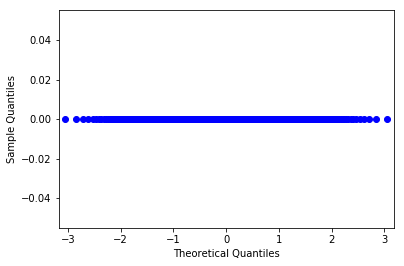

Interval: 5 != normal


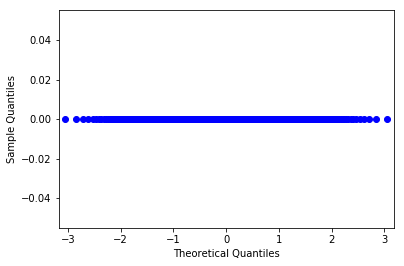

Interval: 10 != normal


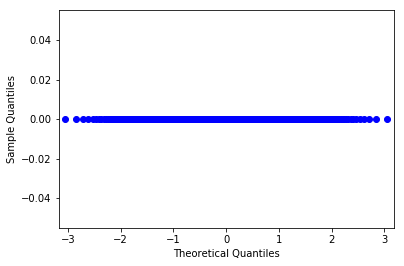

Interval: 15 != normal


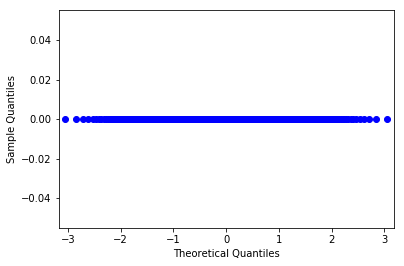

Interval: 20 != normal


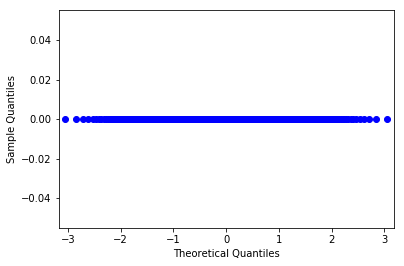

Interval: 25 != normal


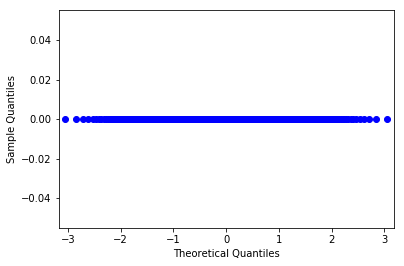

Interval: 30 != normal


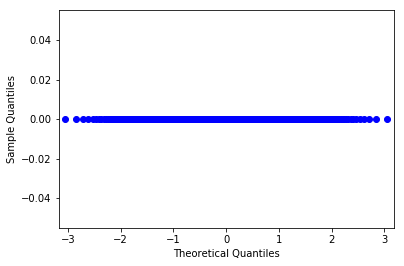

Interval: 35 != normal


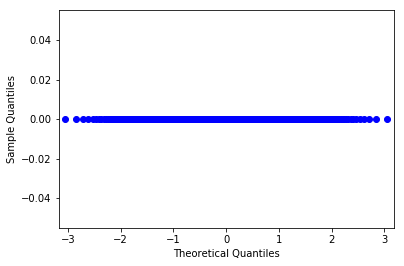

Interval: 40 != normal


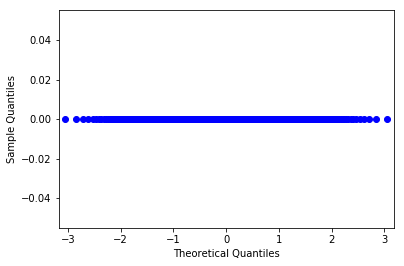

Interval: 45 != normal


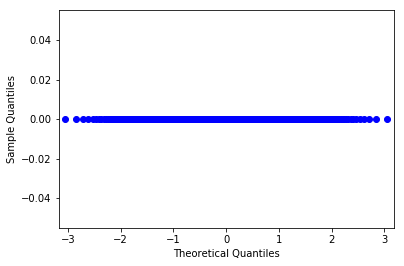

Interval: 50 != normal


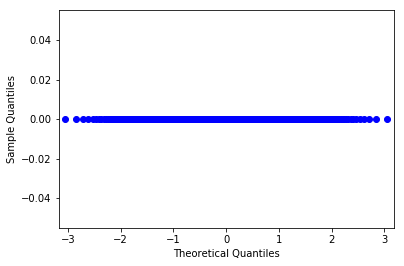

Interval: 55 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=13431.031408641864, pvalue=0.0)
Rejection: kruskal
Dunn-bonferroni output                -10       -15       -20       -25       -30             -5  \
-10   1.000000e+00  1.000000  1.000000  1.000000  1.000000   1.000000e+00   
-15   1.000000e+00  1.000000  1.000000  1.000000  1.000000   9.355524e-01   
-20   1.000000e+00  1.000000  1.000000  1.000000  1.000000   2.149391e-01   
-25   1.000000e+00  1.000000  1.000000  1.000000  1.000000   6.569944e-02   
-30   1.000000e+00  1.000000  1.000000  1.000000  1.000000   8.589240e-03   
-5    1.000000e+00  0.935552  0.214939  0.065699  0.008589   1.000000e+00   
0    2.225054e-283  0.000000  0.000000  0.000000  0.000000  2.649457e-287   
10   2.225054e-283  0.000000  0.000000  0.000000  0.000000  2.649457e-287   
15   2.225054e-283  0.000000  0.000000  0.000000  0.000000  2.649457e-287   
20   2.225054e-283  0.000000  0.000000  0.000000  0.000000  2.649457e-287   
25 

In [452]:
plot_folder = 'dataset_1_all/all/plots'
run_to_rest_data_paths = ["run_to_rest_amplitudes/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_durations/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_proportions/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_sizes/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_speed/range_30_61-step_5range_30_61-step_5-data.csv"]

for data_path in run_to_rest_data_paths:
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)
    
    print(f'For plot: {data_path}')
    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots)

    print('------------\n\n\n\n')

# Figure S3

## Section C - Astrocyte density in BX layers

/Users/achilleasgeorgiou/Desktop/data_output/misc/layer_density_astrocyte_data.csv
   astro_layer_1  astro_layer_2  astro_layer_3  astro_layer_4
0            0.0       3.172428      10.812469        5.39728
1            0.0       4.650038      11.912600        2.95308
2            0.0       2.069057      15.193643        4.20275
3            0.0       6.608708      23.680269        3.80695
4            0.0       4.647070      32.186379        4.86940


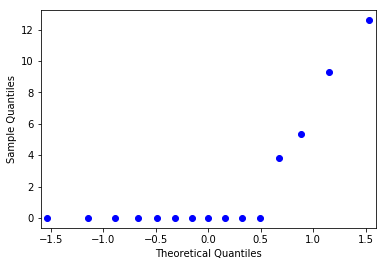

Interval: astro_layer_1 != normal


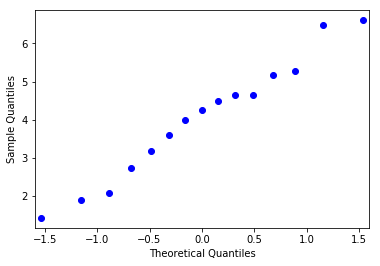

Interval: astro_layer_2 == normal


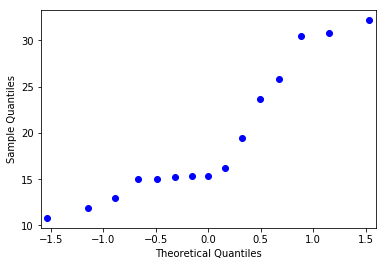

Interval: astro_layer_3 != normal


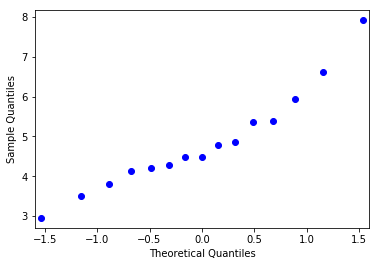

Interval: astro_layer_4 == normal
Non-normal groups -> Kruskal
KruskalResult(statistic=39.279452054794554, pvalue=1.51446897255939e-08)
Rejection: kruskal
Dunn-bonferroni output                astro_layer_1  astro_layer_2  astro_layer_3  astro_layer_4
astro_layer_1   1.000000e+00       0.536169   7.600960e-09       0.087322
astro_layer_2   5.361693e-01       1.000000   7.360686e-05       1.000000
astro_layer_3   7.600960e-09       0.000074   1.000000e+00       0.001712
astro_layer_4   8.732176e-02       1.000000   1.712104e-03       1.000000


In [460]:
plot_folder = 'misc'

data_path = 'layer_density_astrocyte_data.csv'
full_path = os.path.join(base_folder, plot_folder, data_path)
print(full_path)

arr_pd = pd.read_csv(full_path, index_col=0)
print(arr_pd.head())

get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots, normality_test='shapiro')

## Section F - Neuron density in BX layers

   axon_layer_1  axon_layer_2  axon_layer_3  axon_layer_4
0      0.000000      0.000000      5.241551      8.727168
1      0.000000      0.683069      5.181616      6.143110
2      0.000000      0.487914      4.472532      4.601446
3     10.381305      2.476657     16.368975     10.039829
4      0.000000      0.921493     14.150535      7.966867


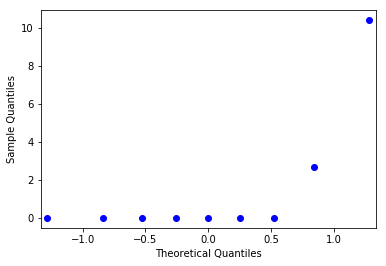

Interval: axon_layer_1 != normal


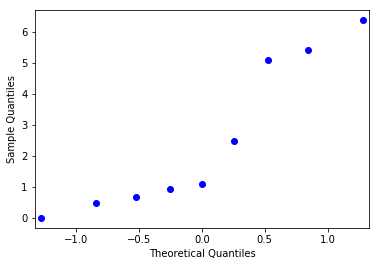

Interval: axon_layer_2 == normal


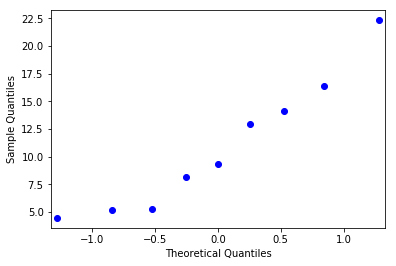

Interval: axon_layer_3 == normal


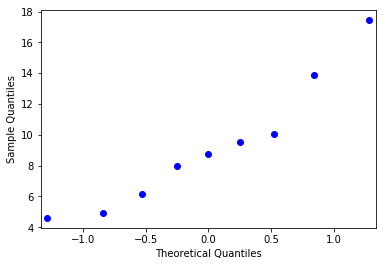

Interval: axon_layer_4 == normal
Non-normal groups -> Kruskal
KruskalResult(statistic=19.84871483505364, pvalue=0.00018244736363773635)
Rejection: kruskal
Dunn-bonferroni output               axon_layer_1  axon_layer_2  axon_layer_3  axon_layer_4
axon_layer_1      1.000000      1.000000      0.001292      0.003329
axon_layer_2      1.000000      1.000000      0.046122      0.093615
axon_layer_3      0.001292      0.046122      1.000000      1.000000
axon_layer_4      0.003329      0.093615      1.000000      1.000000


In [459]:
plot_folder = 'misc'
data_path = os.path.join(base_folder, plot_folder, 'layer_density_neuron_data.csv')

full_path = os.path.join(base_folder, plot_folder, data_path)
arr_pd = pd.read_csv(full_path, index_col=0)

print(arr_pd.head())

get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots, normality_test='shapiro')

# Fig S5

## Section A - rest to run

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_amplitude-data.csv
                                 rest   running
m181129_d190111_c001_day_0   1.794823  1.848458
m2000219_d190411_c003_day_0  1.343808  1.635869
m2000219_d190411_c003_day_1  1.259689  1.288583
m2000219_d190411_c004_day_0  1.393615  1.493766
m2000219_d190411_c004_day_1  1.307464  1.397168


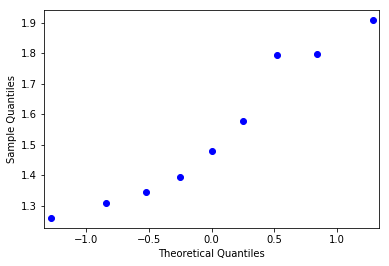

Interval: rest == normal


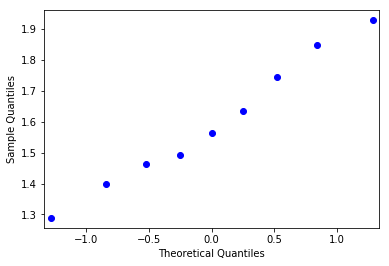

Interval: running == normal
Normality p-values [0.26540622115135193, 0.9062721729278564]
--------------------
Ttest pvalue rest running - Amplitude: ttest_pvalue 0.13789787457278768 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_duration-data.csv
                                 rest   running
m181129_d190111_c001_day_0   1.056171  1.081290
m2000219_d190411_c003_day_0  1.140515  1.409408
m2000219_d190411_c003_day_1  1.143096  1.113064
m2000219_d190411_c004_day_0  0.896800  1.108161
m2000219_d190411_c004_day_1  1.093096  1.218537


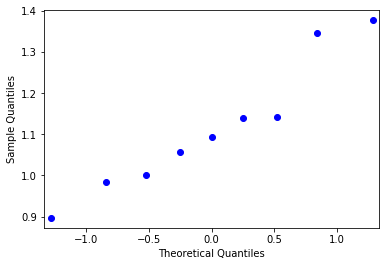

Interval: rest == normal


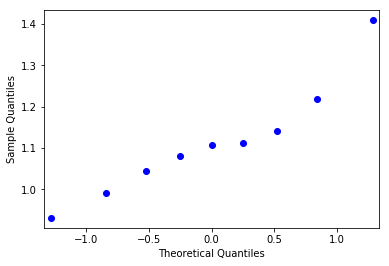

Interval: running == normal
Normality p-values [0.4645790755748749, 0.4681706130504608]
--------------------
Ttest pvalue rest running - Duration: ttest_pvalue 0.9987631988440868 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_Event number (per minute)-data.csv
                                   rest     running
m181129_d190111_c001_day_0   122.477732  224.470415
m2000219_d190411_c003_day_0   51.372111  280.720813
m2000219_d190411_c003_day_1   40.423839   99.622946
m2000219_d190411_c004_day_0   22.829459  163.845015
m2000219_d190411_c004_day_1   82.823944  185.570907


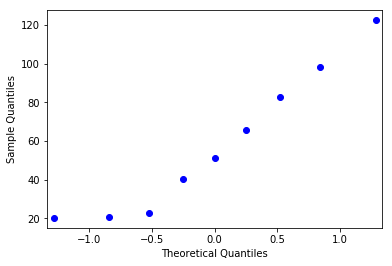

Interval: rest == normal


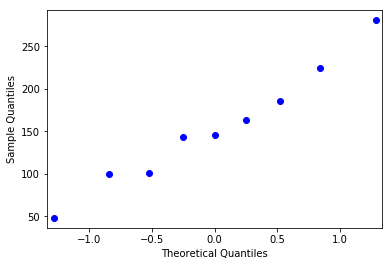

Interval: running == normal
Normality p-values [0.34575238823890686, 0.9597190618515015]
--------------------
Ttest pvalue rest running - Event number: ttest_pvalue 0.0013545542607984354 -> rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_size-data.csv
                                 rest    running
m181129_d190111_c001_day_0   6.197367   8.353198
m2000219_d190411_c003_day_0  6.302203  10.506539
m2000219_d190411_c003_day_1  6.871263   7.516613
m2000219_d190411_c004_day_0  4.826425   8.686314
m2000219_d190411_c004_day_1  6.400439   9.763890


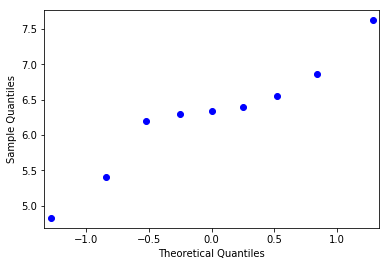

Interval: rest == normal


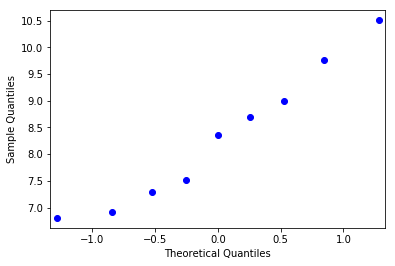

Interval: running == normal
Normality p-values [0.6281329393386841, 0.5787814259529114]
--------------------
Ttest pvalue rest running - Size: ttest_pvalue 0.002778064312742447 -> rejected
--------------------


In [461]:
col_filt = ['rest', 'running']

plot_folder = 'dataset_1_all/all/plots'

identifiers = ['Amplitude', 'Duration', 'Event number', 'Size']
rest_run_data_paths = ["transition_dots_rest_run/dots_amplitude-data.csv",
                            "transition_dots_rest_run/dots_duration-data.csv",
                            "transition_dots_rest_run/dots_Event number (per minute)-data.csv",
                            "transition_dots_rest_run/dots_size-data.csv"]

for i, data_path in enumerate(rest_run_data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    arr_pd = arr_pd[col_filt]
    print(arr_pd.head())

    rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

    print('Normality p-values', normality_results)

    #Paired two tailed ttest
    ttest_pvalue = two_tailed_ttest(arr_pd, col_filt[0], col_filt[1], is_unpaired=False)

    print('--------------------')
    print(f'Ttest pvalue {col_filt[0]} {col_filt[1]} - {identifiers[i]}: ttest_pvalue {ttest_pvalue} -> {"rejected" if ttest_pvalue < 0.05 else "not-rejected"}')
    print('--------------------')



## Section B - Rest to vibrisa exploration

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_amplitude-data.csv
                                 rest  stick_rest
m181129_d190111_c001_day_0   1.794823    1.816852
m2000219_d190411_c003_day_0  1.343808    1.374178
m2000219_d190411_c003_day_1  1.259689    1.212675
m2000219_d190411_c004_day_0  1.393615    1.381925
m2000219_d190411_c004_day_1  1.307464    1.330125


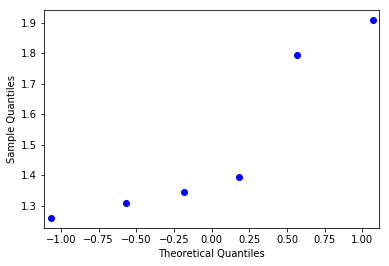

Interval: rest == normal


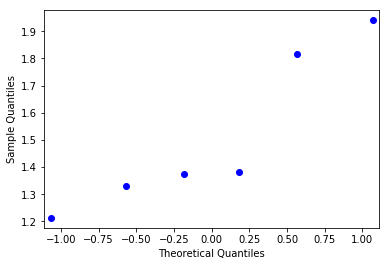

Interval: stick_rest == normal
Normality p-values [0.07377438247203827, 0.13546758890151978]
--------------------
Ttest pvalue rest stick_rest - Amplitude: ttest_pvalue 0.5509654189431621 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_duration-data.csv
                                 rest  stick_rest
m181129_d190111_c001_day_0   1.056171    0.821267
m2000219_d190411_c003_day_0  1.140515    1.141004
m2000219_d190411_c003_day_1  1.143096    1.103375
m2000219_d190411_c004_day_0  0.896800    0.903330
m2000219_d190411_c004_day_1  1.093096    1.081511


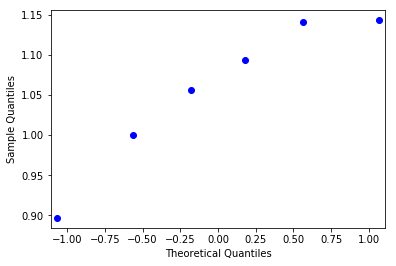

Interval: rest == normal


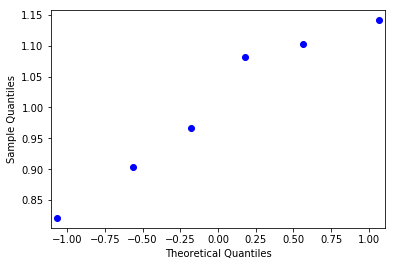

Interval: stick_rest == normal
Normality p-values [0.4147757887840271, 0.5725123286247253]
--------------------
Ttest pvalue rest stick_rest - Duration: ttest_pvalue 0.22076969704337515 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_Event number (per minute)-data.csv
                                   rest  stick_rest
m181129_d190111_c001_day_0   122.477732  173.943798
m2000219_d190411_c003_day_0   51.372111   59.847232
m2000219_d190411_c003_day_1   40.423839   46.928279
m2000219_d190411_c004_day_0   22.829459   25.469232
m2000219_d190411_c004_day_1   82.823944   73.676214


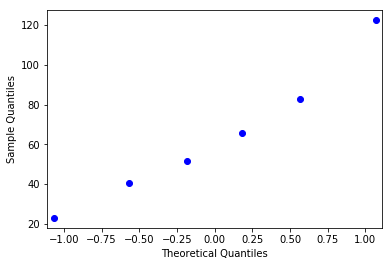

Interval: rest == normal


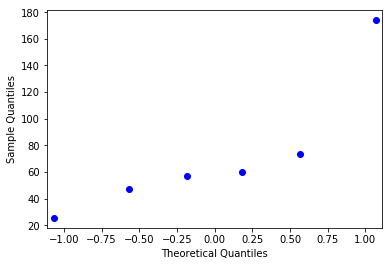

Interval: stick_rest != normal
Normality p-values [0.8490149974822998, 0.043686263263225555]
--------------------
Ttest pvalue rest stick_rest - Event number: ttest_pvalue 0.39053967966997133 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_size-data.csv
                                 rest  stick_rest
m181129_d190111_c001_day_0   6.197367    6.857915
m2000219_d190411_c003_day_0  6.302203    6.636193
m2000219_d190411_c003_day_1  6.871263    6.105774
m2000219_d190411_c004_day_0  4.826425    5.146491
m2000219_d190411_c004_day_1  6.400439    5.882350


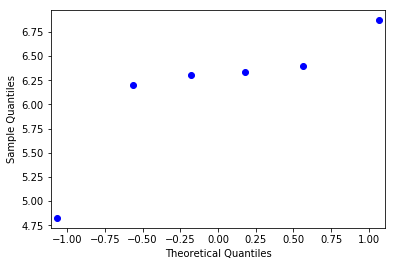

Interval: rest != normal


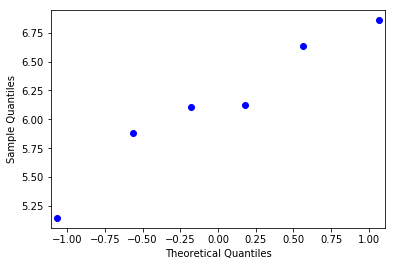

Interval: stick_rest == normal
Normality p-values [0.046942006796598434, 0.7410587668418884]
--------------------
Ttest pvalue rest stick_rest - Size: ttest_pvalue 0.8971145867100674 -> not-rejected
--------------------


In [462]:
col_filt = ['rest', 'stick_rest']

plot_folder = 'dataset_1_all/all/plots'

identifiers = ['Amplitude', 'Duration', 'Event number', 'Size']
rest_rest_stick_data_paths = ["transition_dots_rest_rest_stick/dots_amplitude-data.csv",
                            "transition_dots_rest_rest_stick/dots_duration-data.csv",
                            "transition_dots_rest_rest_stick/dots_Event number (per minute)-data.csv",
                            "transition_dots_rest_rest_stick/dots_size-data.csv"]

for i, data_path in enumerate(rest_rest_stick_data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    arr_pd = arr_pd[col_filt]
    print(arr_pd.head())

    rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

    print('Normality p-values', normality_results)

    #Paired two tailed ttest
    ttest_pvalue = two_tailed_ttest(arr_pd, col_filt[0], col_filt[1], is_unpaired=False)

    print('--------------------')
    print(f'Ttest pvalue {col_filt[0]} {col_filt[1]} - {identifiers[i]}: ttest_pvalue {ttest_pvalue} -> {"rejected" if ttest_pvalue < 0.05 else "not-rejected"}')
    print('--------------------')



## Section C - Run to vibrisa stimulation

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_amplitude-data.csv
                              running  stick_run_ind_15
m181129_d190111_c001_day_0   1.848458          1.891501
m2000219_d190411_c003_day_0  1.635869          1.729852
m2000219_d190411_c003_day_1  1.288583          1.262413
m2000219_d190411_c004_day_0  1.493766          1.503124
m2000219_d190411_c004_day_1  1.397168          1.392630


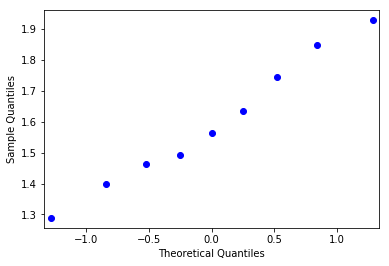

Interval: running == normal


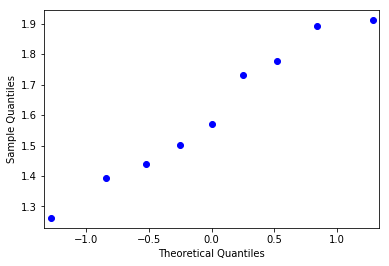

Interval: stick_run_ind_15 == normal
Normality p-values [0.9062721729278564, 0.6489120125770569]
--------------------
Ttest pvalue running stick_run_ind_15 - Amplitude: ttest_pvalue 0.362188294003326 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_duration-data.csv
                              running  stick_run_ind_15
m181129_d190111_c001_day_0   1.081290          1.097247
m2000219_d190411_c003_day_0  1.409408          1.402719
m2000219_d190411_c003_day_1  1.113064          1.100969
m2000219_d190411_c004_day_0  1.108161          1.142847
m2000219_d190411_c004_day_1  1.218537          1.209620


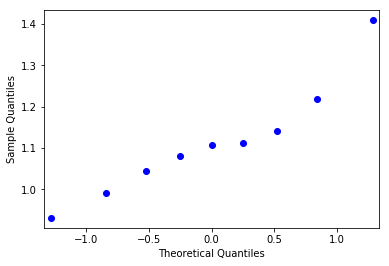

Interval: running == normal


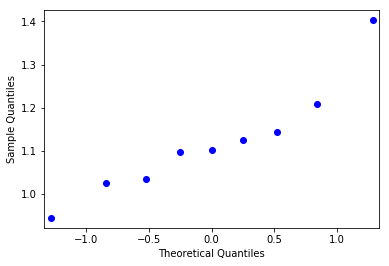

Interval: stick_run_ind_15 == normal
Normality p-values [0.4681706130504608, 0.3618677258491516]
--------------------
Ttest pvalue running stick_run_ind_15 - Duration: ttest_pvalue 0.45113883600958127 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_Event number (per minute)-data.csv
                                running  stick_run_ind_15
m181129_d190111_c001_day_0   224.470415        270.903529
m2000219_d190411_c003_day_0  280.720813        366.663588
m2000219_d190411_c003_day_1   99.622946        102.634194
m2000219_d190411_c004_day_0  163.845015        189.779370
m2000219_d190411_c004_day_1  185.570907        202.434121


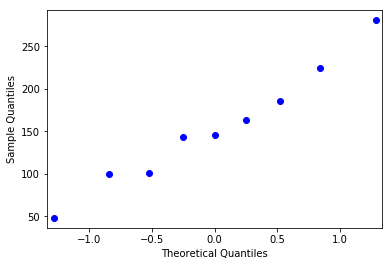

Interval: running == normal


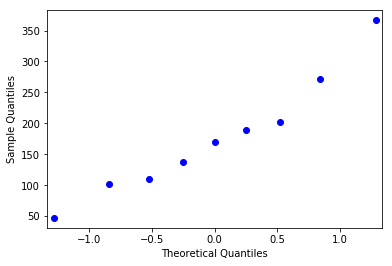

Interval: stick_run_ind_15 == normal
Normality p-values [0.9597190618515015, 0.7457038164138794]
--------------------
Ttest pvalue running stick_run_ind_15 - Event number: ttest_pvalue 0.041468895782661844 -> rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_size-data.csv
                               running  stick_run_ind_15
m181129_d190111_c001_day_0    8.353198          9.612251
m2000219_d190411_c003_day_0  10.506539         12.491580
m2000219_d190411_c003_day_1   7.516613          7.888216
m2000219_d190411_c004_day_0   8.686314          9.757819
m2000219_d190411_c004_day_1   9.763890         10.540225


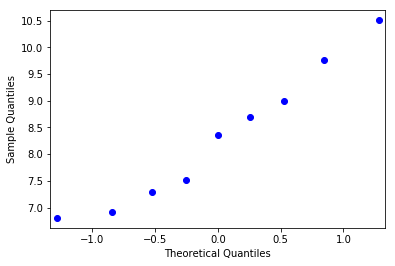

Interval: running == normal


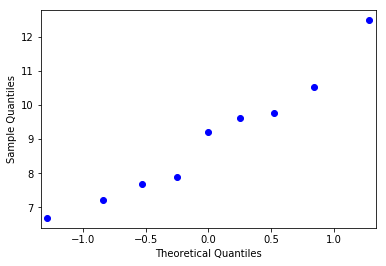

Interval: stick_run_ind_15 == normal
Normality p-values [0.5787814259529114, 0.6860499978065491]
--------------------
Ttest pvalue running stick_run_ind_15 - Size: ttest_pvalue 0.012765643264538655 -> rejected
--------------------


In [463]:
col_filt = ['running', 'stick_run_ind_15']

plot_folder = 'dataset_1_all/all/plots'

identifiers = ['Amplitude', 'Duration', 'Event number', 'Size']
run_run_stick_data_paths = ["transition_dots_run_run_stick/dots_amplitude-data.csv",
                            "transition_dots_run_run_stick/dots_duration-data.csv",
                            "transition_dots_run_run_stick/dots_Event number (per minute)-data.csv",
                            "transition_dots_run_run_stick/dots_size-data.csv"]

for i, data_path in enumerate(run_run_stick_data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    arr_pd = arr_pd[col_filt]
    print(arr_pd.head())

    rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

    print('Normality p-values', normality_results)

    #Paired two tailed ttest
    ttest_pvalue = two_tailed_ttest(arr_pd, col_filt[0], col_filt[1], is_unpaired=False)

    print('--------------------')
    print(f'Ttest pvalue {col_filt[0]} {col_filt[1]} - {identifiers[i]}: ttest_pvalue {ttest_pvalue} -> {"rejected" if ttest_pvalue < 0.05 else "not-rejected"}')
    print('--------------------')


# Figure S7

## (Section B)

/Users/achilleasgeorgiou/Desktop/data_output/single_multi_stick/plots/bar_comparison/area-data.csv


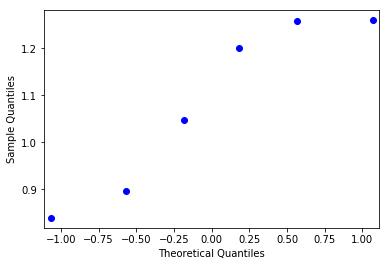

Interval: running == normal


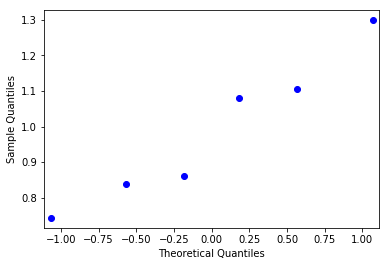

Interval: single == normal


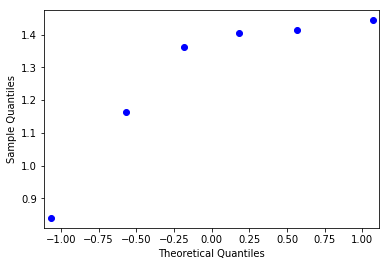

Interval: multi != normal
Force parametric: Anova, num normal groups: 2/3
F_onewayResult(statistic=2.839617898963958, pvalue=0.08998617727100594)
/Users/achilleasgeorgiou/Desktop/data_output/single_multi_stick/plots/bar_comparison/count-data.csv


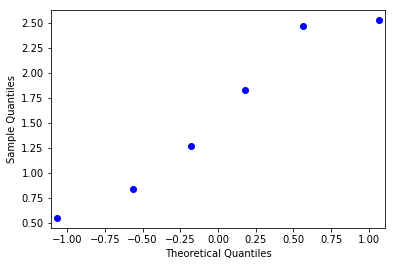

Interval: running == normal


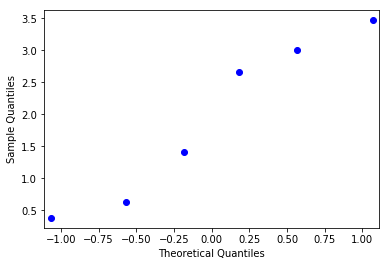

Interval: single == normal


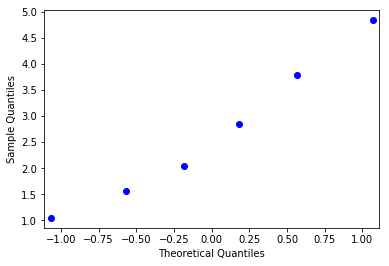

Interval: multi == normal
Force parametric: Anova, num normal groups: 3/3
F_onewayResult(statistic=1.309666968290121, pvalue=0.29906341777075085)
/Users/achilleasgeorgiou/Desktop/data_output/single_multi_stick/plots/bar_comparison/dffMax2-data.csv


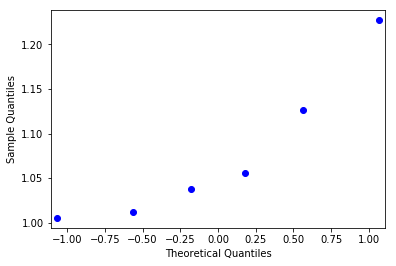

Interval: running == normal


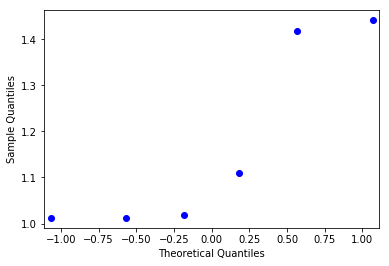

Interval: single != normal


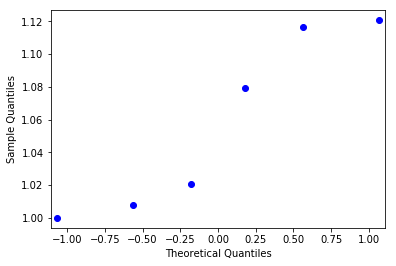

Interval: multi == normal
Force parametric: Anova, num normal groups: 2/3
F_onewayResult(statistic=1.2094484466834765, pvalue=0.32585889417262)
/Users/achilleasgeorgiou/Desktop/data_output/single_multi_stick/plots/bar_comparison/time_s-data.csv


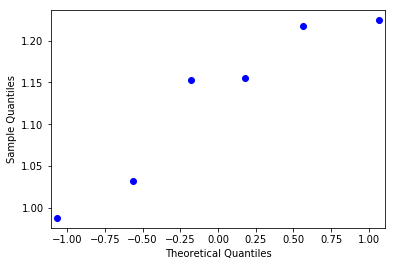

Interval: running == normal


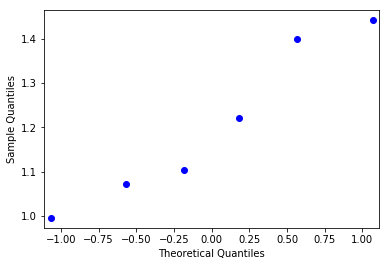

Interval: single == normal


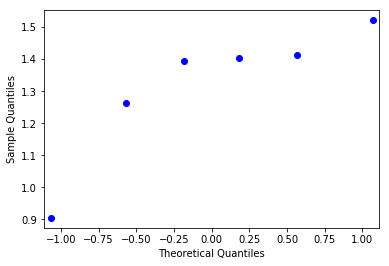

Interval: multi == normal
Force parametric: Anova, num normal groups: 3/3
F_onewayResult(statistic=1.794780167414707, pvalue=0.20006266771736608)


In [472]:
plot_folder = 'single_multi_stick'

data_paths = ['plots/bar_comparison/area-data.csv', 
             'plots/bar_comparison/count-data.csv', 
             'plots/bar_comparison/dffMax2-data.csv', 
             'plots/bar_comparison/time_s-data.csv'
             ]

for i, data_path in enumerate(data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    # Size - multi-stick not normal p_value = 0.03767292946577072
    # Amplitude - single-stick not normal p_value = 0.01976897567510605
    # We decide to use Anova nonetheless (force anova)
    
    #rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')
    #print(normality_results)


    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots, normality_test='shapiro', force_parametric=True)
    

# Figure S9

## (Section B)

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/split_correlation_all/splits-data-old-random.csv


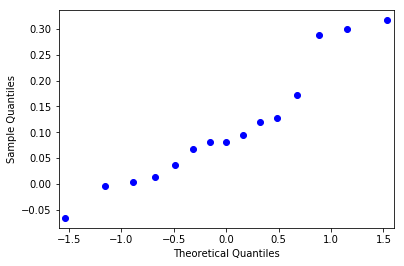

Interval: Random == normal


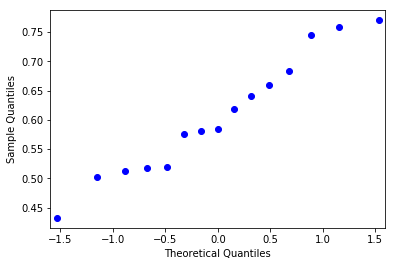

Interval: Self splits == normal


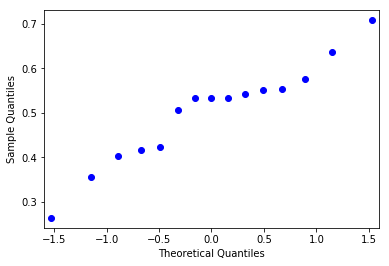

Interval: Rest-Run splits == normal


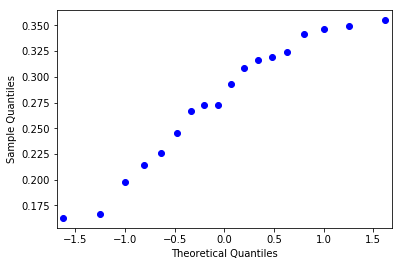

Interval: Day 0-1 Splits == normal
Normal groups -> Anova
F_onewayResult(statistic=77.765486222033, pvalue=1.7538669888356852e-20)
Rejection: anova
Tukey output          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
 Day 0-1 Splits          Random  -0.1676  0.001 -0.2591 -0.0762   True
 Day 0-1 Splits Rest-Run splits   0.2256  0.001  0.1342  0.3171   True
 Day 0-1 Splits     Self splits   0.3304  0.001   0.239  0.4219   True
         Random Rest-Run splits   0.3933  0.001  0.2978  0.4888   True
         Random     Self splits    0.498  0.001  0.4025  0.5936   True
Rest-Run splits     Self splits   0.1048 0.0262  0.0093  0.2003   True
----------------------------------------------------------------------


In [465]:
plot_folder = 'dataset_1_all/all/plots'
#Using the exact .csv file used in figure paper
data_path = 'split_correlation_all/splits-data-old-random.csv'

full_path = os.path.join(base_folder, plot_folder, data_path)
print(full_path)

arr_pd = pd.read_csv(full_path, index_col=0)
arr_pd.head()

get_stats_multiple_groups(arr_pd, show_qq_plot=True, normality_test='shapiro')



